In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt 

from pymongo import MongoClient

In [3]:
# for vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import Normalizer

#preprocessing
from sklearn.preprocessing import Normalizer

In [2]:
import datetime as dt 

start = dt.datetime.now()
#print ('test')

print "the loading took {} seconds ".format((dt.datetime.now()-start).seconds)

the loading took 0 seconds 


In [4]:
# connect to nytime database

client = MongoClient()

db = client.nyt
nyt_fulltext = db.nyt_fulltext

nyt_data = db.nyt_data

This model aims to find recommendations of articles from January - July 2016 based on a user's previous article choices. At this point the articles have already been extracted using the ** NYT API ** and imported into a MongoDB table.  After preprocessing that involves removal of stop-words and characters (punctation mostly), the text is vectorized (TFIDF) testing out one- and two-grams.  
Topics are extracted from a corpus of articles from that time period. 


### Model pipeline

1. Read in data from MongodDB 
2. extract text from each article
3. text needs to remove stop words, commas, 
    1. use tfidf here, it will do this for you
4. get vectors for the document
5. np.mean() for the vectors, get one mean vector for document
6. take cosine similarity with reference document
7. pick N top choices for Recommendations

In [5]:
nyt_fulltext.count()

9644

### Step 1: extract text

In [9]:
''' retrieve full corpus'''
test = list(db.nyt_fulltext.find({},{"article": 1,
                                    "query": 1,
                                    "headline": 1,
                                      "date" : 1
                                    #timeStamp: {$lte: <20160601>, 
                                  #  $gte : <20160518>}
   }) ) #.limit(4000))

# consider also "snippet" :1
# later do whole text

In [ ]:
# t = []
# for a in range(500):
#     t.append(test[a]['query'])
# test = test[0:5890]
# holdout = test[-4:]

In [10]:
df = pd.DataFrame(test, columns=["query", 'article', 'headline', 'date'] )
df[:3]

,query,article,headline,date
0,economics,"BIDDEFORD, Me. When Kylie Galliani started at...","With Free Bikes, Challenging Car Culture on Ca...",2008-10-20
1,economics,"In the video below, CNBC reports anew on New Y...",Wind Turbines in New York?,2008-10-20
2,economics,Is Europe no longer an economic museum? In rec...,"Suddenly, Europe Looks Pretty Smart",2008-10-20


In [19]:
#Use the first 6 months
df2 = df[(df['date'] > '2016-01-01') & (df['date'] < '2016-06-31')]

In [17]:
df2.shape

(6714, 4)

In [18]:
df2['query'].unique()

array([u'economics', u'politics', u'tech', u'business', u'sports', u'music'], dtype=object)

In [20]:
df['query'].unique()

array([u'economics', u'politics', u'tech', u'business', u'sports', u'music'], dtype=object)

In [9]:
#df[df.article.isnull()].count()

In [21]:
df.dropna(axis=0,inplace=True)

In [22]:
df[df.article.isnull()].count()

query       0
article     0
headline    0
date        0
dtype: int64

In [23]:
df.drop_duplicates(subset=['headline'], inplace=True)

In [24]:
df.shape

(8291, 4)

In [21]:
# df_test = pd.DataFrame(holdout, columns=["query", 'article','headline'] )
# df_test

,query,article,headline
0,business,MINNEAPOLIS The snapped football flew high an...,Seahawks Pull a Win From Their Long Sleeves
1,business,PHOENIX Bobby Williams got his first break as...,Knocking at Opportunity From Alabama’s Sideline
2,business,(Want to get this briefing by email? Heres the...,"Your Monday Briefing: Hillary Clinton, Golden ..."
3,business,"Since leaving IMG, the sports and media powerh...",Bruin Sports to Team Up With Others as Investor


In [25]:
#df.iloc[0,1]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8291 entries, 0 to 9643
Data columns (total 4 columns):
query       8291 non-null object
article     8291 non-null object
headline    8291 non-null object
date        8291 non-null object
dtypes: object(4)
memory usage: 323.9+ KB


In [26]:
df['query'].unique()

array([u'economics', u'politics', u'tech', u'business', u'sports', u'music'], dtype=object)

In [ ]:
#df[df.query.isnull()].count()

# step 2: preprocessing of the text
= try 2-grams

In [27]:

from nltk.corpus import stopwords
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"']
stop += ['would','one','like', 'mr','ms','also','could','said','should',
     'first', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight'
    , 'nine', 'ten', 'mrs', 'years','last', 'im' ,'dont','street', 'think',
        'time', 'many', 'even', 'sanderss', 'york', 'new', 'companies', 'trumps'
        , 'donald', 'bernie','apples', 'de', 'com', 'year',
        'percent', 'much', 'cruzs', 'clintons', 'care', 'rose','org',
        'make', 'ted', 'dr', 'start','union','news','program','banks', 'central',
        'chinas','greeces', 'greek', 'big' ]

stop[-5:]

['central', 'chinas', 'greeces', 'greek', 'big']

In [28]:
#tfidf = TfidfVectorizer(stop, min_df=5, ngram_range=(1,1) )
## token pattern should get rid off  the numbers

CountVectorizer
tfidf = TfidfVectorizer(stop_words=stop,min_df=20, token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b",
                        # lowercase=True, # default
                        ngram_range=(1,2) )

In [29]:
tfidf_vecs = tfidf.fit_transform(df.article)
#tfidf_vecs = tfidf.fit_transform(df_smaller.article)

In [30]:
X = pd.DataFrame(tfidf_vecs.todense(),
             columns=tfidf.get_feature_names())
X[:3]

,aaron,aaron curry,abacus,abacus zoology,abandon,abandoned,abandoning,abandonment,abbey,abbott,...,zombies,zone,zone discovering,zones,zoning,zoo,zoology,zoology may,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


-  min_df=5,  ngram_range=(1,1) , 23812 columns
- min_df=5,  ngram_range=(1,2),  140938 columns
- min_df=20,  ngram_range=(1,2),  31786 columns
- **min_df=20,  ngram_range=(1,1),   10095 columns  **

+ stop words (modified)
- **min_df=20,  ngram_range=(1,1),  9950 columns **

### with all but last 4 articles:
- **min_df=20,  ngram_range=(1,1),  12835 columns **



Can also do Count Vectorizer (how many words I have in doc)
### play with Vectorizer methods

In [193]:
#tfidf_vecs.check_format
#tfidf.analyzer
###''' i do this later anyway'''
features = list(tfidf.get_feature_names())
features[:5000:500]

[u'aaron',
 u'american international',
 u'authority',
 u'bolster',
 u'caterpillar',
 u'college tuition',
 u'corona',
 u'deliberately',
 u'dominate',
 u'enforcement']

### LSA :   Dimension Reduction / Feature Extraction
- tall skinny + short wide matrices
#### Number of topics
+ 50
+ try 20/15

In [194]:
'''
pass the raw tfidf_vecs (not the dataframe to the LSA fransform )
first param = Desired dimensionality of output data. Must be strictly less than the number of features. 
The default value is useful for visualisation. For LSA, a value of 100 is recommended


try: 50/100
'''

lsa = TruncatedSVD(20, algorithm = 'arpack')
reduced_mat = lsa.fit_transform(tfidf_vecs)

In [195]:
#It calculates the sum of squares for each row (the "fit" part) and 
## then divides each row by that amount (the "transform" part).  This just ensures that 
#each vector has a "norm" of 1
## Vectors with a norm of 1 are easy to work with for calculating similarity.
reduced_mat = Normalizer(copy=False).fit_transform(reduced_mat)

In [196]:
'''
count_mat == tfidf_vecs
'''
#count_mat.shape, reduced_mat.shape

tfidf_vecs.shape, reduced_mat.shape

((5028, 15465), (5028, 20))

+ ** num documents** 5831 
+ ** num features as words/tokens** 12835   (9950 (old: 10095)
+ ** dimensionality of output data ** 15  

## Explore the most important words in each topic / dimension

In [197]:
terms = np.array(tfidf.get_feature_names())
terms[:5000: 250]

array([u'aaron', u'advertisements', u'american international',
       u'archaeology', u'authority', u'begun', u'bolster', u'bureau chief',
       u'caterpillar', u'christianity', u'college tuition',
       u'conflict interest', u'corona', u'current', u'deliberately',
       u'different story', u'dominate', u'economics london',
       u'enforcement', u'example'], 
      dtype='<U27')

In [202]:
## This is a simple convenience function which gets the highest valued terms for each topic
"""
topic-mat is the LSA matrix (see above) lsa.components
i, topic number
term_vec: all the different column values (from vectorized matrix above)
    we called this terms, it's all the terms extracted from the vectoriztion process
    
    argsort sorts vectors in acsending order the (- ...) minus, sorts it in descending order
"""
def get_topical_terms(topic_mat, topic_num, term_vec, num_terms=35):
    return term_vec[np.argsort(-topic_mat[topic_num,:])][:num_terms]

In [203]:
## Print the highest valued terms for each of the first 10 topics
'''
topic 0 is the strongest topic/ has highest eigenvectors

lsa.components_  // short wide matrix of giving a weight to each word within each topic
'''
for i in range(20):
    print("topic {}".format(i))
    print(get_topical_terms(lsa.components_,i,terms, 35))
    
#     ['would','one','like', 'mr','ms','also','could','said','should',
#      'first', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight'
#     , 'nine', 'ten']

# ['new', 'mrs'] New could be now york

topic 0
[u'people' u'trump' u'clinton' u'president' u'states' u'state'
 u'republican' u'government' u'obama' u'economic' u'american' u'company'
 u'united' u'economy' u'campaign' u'sanders' u'political' u'party'
 u'united states' u'tax' u'world' u'work' u'million' u'cruz' u'get' u'may'
 u'money' u'way' u'well' u'business' u'republicans' u'house' u'still'
 u'policy' u'say']
topic 1
[u'trump' u'clinton' u'cruz' u'iowa' u'sanders' u'republican' u'campaign'
 u'senator' u'voters' u'rubio' u'republicans' u'candidates' u'hampshire'
 u'obama' u'bush' u'hillary' u'democratic' u'presidential' u'candidate'
 u'party' u'caucuses' u'debate' u'democrats' u'president' u'polls'
 u'hillary clinton' u'primary' u'race' u'christie' u'conservative'
 u'election' u'gun' u'caucus' u'poll' u'immigration']
topic 2
[u'art' u'school' u'students' u'museum' u'life' u'theater' u'city' u'show'
 u'music' u'children' u'film' u'family' u'book' u'college' u'young' u'work'
 u'brooklyn' u'people' u'women' u'love' u'sunday' u

In [31]:
terms_names = ['Politics', 'Election primaries', 'Business&Economy', 'Sports', 
               'NYT editorials&comments', "Events in NYC", #5
               "Democrats News", 'Education', 'Tech News ',#8
               , "NYC local", "Justice department",'Theater&Broadway', #11
               , "Higher Education" , "University sports","Music", #14
               "Museums&Art", 'Republican News','Olympics 2016',#17
               "Trends on twitter", 'Election 2016'            
              ]

In [314]:
# possible classifications for 15 topics
# [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
#['government', 'election--primaries','election--banks/economics', 'election-- tech market', 'election- ' ]

terms_names = ['government', 'election--primaries','art & culture','business& technology','Democrat news',
               'national security','europe & economics','university sports', 'sports',
               'international finance /china','Music&Entertainment', 'TPP and trade','Sunday edition (summary)',
               'climate & energy','party politics','Republican news','White house news',
'Justice department','Education','Smart Phones']

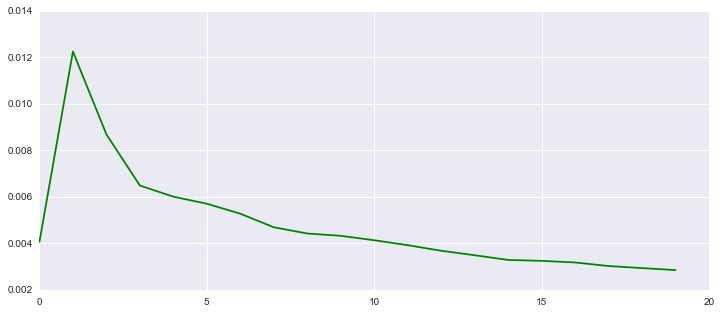

In [209]:
lsa.components_.shape # short and wide matrix
#lsa.components_
#reduced_mat
#pd.DataaFrame(lsa.components_)
# output: 50 rows × 10095 columns
plt.figure(figsize=(12,5))
plt.plot(lsa.explained_variance_ratio_, color='green',marker = '+')#,'r+')

## Explore which documents are similar to which others

In [210]:
reduced_mat.shape

(5028, 20)

In [213]:
# might take a while
start = dt.datetime.now()
#print ('test')
sim_mat = np.dot(reduced_mat, reduced_mat.T)

print "the loading took {} seconds ".format((dt.datetime.now()-start).seconds)
#sim_mat.shape
#get_similar_docs(reduced_mat[2535,:],reduced_mat)
#get_similar_docs(reduced_mat[123,:],reduced_mat)

the loading took 0 seconds 


## Test the holdout set
1. use vectorizer tfidf, to 'transform' the holdout set, you don't wanna fit_transform here


In [45]:
df.article[63][:500]

u'This summer, when the Treasury secretary, Henry M. Paulson Jr., sought help navigating the Wall Street meltdown, he turned to his old firm, Goldman Sachs, snagging a handful of former bankers and other experts in corporate restructurings, The New York Timess Julie Creswell and Ben White reported. In September, after the government bailed out the American International Group, the faltering insurance giant, for $85 billion, Mr. Paulson helped select a director from Goldmans own board to lead A.I.G'

In [46]:
#NOTE: below we just use "transform" not "fit_transform"
tfidf_vec_test = tfidf.transform(df_test.article)
reduced_mat_test = lsa.transform(tfidf_vec_test)


# For the Normalizer, we do a fit_transform, because this is just a division by a constant of each row
reduced_mat_test = Normalizer(copy=False).fit_transform(reduced_mat_test)

In [47]:
reduced_mat_test.shape

(4, 50)

In [48]:
reduced_mat_test[1]

array([ 0.56519557,  0.03500484,  0.28676829, -0.00108777, -0.0791152 ,
       -0.02747731,  0.00755793,  0.10826592,  0.11372057, -0.00140667,
       -0.27821334,  0.35505217,  0.21879668,  0.02924652,  0.00772971,
       -0.06788946,  0.0367779 , -0.00600234, -0.0422613 ,  0.07889285,
       -0.00619056, -0.002643  ,  0.11800995, -0.04327226, -0.14848918,
        0.09457409,  0.03018636,  0.01649967, -0.10543082, -0.07301131,
        0.10757678,  0.16939261,  0.19751211, -0.07706407,  0.07551707,
        0.00883721, -0.15154283, -0.16366294,  0.07330741, -0.17647199,
       -0.04336024, -0.05359108, -0.03429203,  0.07323775,  0.0291328 ,
       -0.08814713,  0.11513346,  0.09267815, -0.09764993, -0.07798702])

In [49]:
len(reduced_mat_test)

4

In [51]:
''' generate a random article from holdout
    but not from the dataframe, do it from 
     choose the Transformed, Normalized vector matrix:reduce_mat_test '''
def gen_article(df):
        num = np.random.choice(len(df))
    return num, df[num]

In [228]:
## This is a simple convenience function - given one vector representation of a document and 
## the representation of a corpus, return the (indices of) the most similar documents
'''
give me a vector that represetns a single document, give me a corpus (matrix of other do)
'''
def get_similar_docs(target_vec, corpus_vecs, num_res=5):
    sim_scores = np.dot(target_vec, corpus_vecs.T)
    return np.argsort(-sim_scores)[:num_res]

In [95]:

which_article, choice_reduced_test = gen_article(reduced_mat_test)

In [96]:
# test similarity (on randomly generated holdout set)

get_similar_docs(choice_reduced_test, reduced_mat)

array([5827, 5456, 5750,  954, 5562])

In [ ]:
df_test.locwhich_article
which_article


In [119]:
''' generate article from holdout AND print out 5 most pertinent articles
    'input' - 
    choice_vec_matrix :: data from which to generate choice article
                                 - can be holdout set
                                 - can be from a particular section of main set
    data_set :: whatever the data is 

'''
def print_recommended(choice_vec_matrix, data_set):
    ## randomly generate article from holdout
    ## get index of DF, and choice_test is the vector matrix
    num_test, choice_test = gen_article(choice_vec_matrix)
    array_five = get_similar_docs(choice_test, reduced_mat)
    #print array_five
    #snip = []
    #title = []
    
    print " num_test, choice+test", num_test
    print " chosen article: ", data_set.iloc[num_test, :]['headline'][:] , "\n"
    #print " array ", array_five
    for a in array_five[1:]:
        #print "a is ", a
        snip =  df.iloc[a,:]['article'][:500] 
        title =  df.iloc[a,:]['headline'][:500] 
        print "\t", title
        print snip , '\n'
   # print "\n".join(title)

In [120]:
# generate article from main set
print_recommended(reduced_mat, df)

 num_test, choice+test 1827
 chosen article:  Tracy Roosevelt, Robert O’Loughlin 

	Anna Schecter, Dov Zigler
Anna Ruth Augusta Schecter and Dov Zigler are to be married Sunday at the Thomas Fogarty Winery in Woodside, Calif. Rabbi Eric Grossman is to officiate. The bride, 34, works in New York as a producer for NBC News. She graduated summa cum laude from Middlebury College. She is the daughter of Dr. Gisela F. Schecter and Dr. William P. Schecter of San Francisco. Her mother retired as the lead consultant of the Multidrug-Resistant Tuberculosis Service at the California Department of Public Health. He 

	Sarah Lieber, Jonathan Wachter
Dr. Sarah Beth Lieber and Jonathan David Wachter are to be married July 3 in New York. Rabbi Hirschy Zarchi will officiate at the Mandarin Oriental hotel. The bride, 31, completed her first year of a rheumatology fellowship at the Hospital for Special Surgery in New York and is to spend the next academic year as a chief resident in internal medicine at 

In [121]:
# generate article from holdout set :: test against whole corpu
print_recommended(reduced_mat_test, df_test)

 num_test, choice+test 1
 chosen article:  Knocking at Opportunity From Alabama’s Sideline 

	Jets Want Quantity From Draft, but Also a Potentially Costly Prospect in Marcus Mariota
FLORHAM PARK, N.J.   Mike Maccagnan graduated from Trinity College expecting to become not a football scout but a financial analyst. He applied for positions on Wall Street but then chose to pursue a career working in the N.F.L., where he has still managed to put his degree in economics to good use. Heading into his first draft as the Jets general manager, Maccagnan compared his approach  assessing risks, projecting returns  to that of a portfolio manager. Do you pick one stock that you think is 

	Michigan Makes It Official: Jim Harbaugh Is the Football Coach
ANN ARBOR, Mich.   It all seemed so familiar as Jim Harbaugh stood on a podium Tuesday and discussed becoming Michigans football coach. In the first few rows were his wife and children, the former Michigan coaches Lloyd Carr and Gary Moeller, and Kath

In [ ]:
df.iloc[5830,:]['article'][:500]

In [ ]:
df_test.iloc[which_article,:]['article'][:500]


# User input Functions

In [215]:
def gen_article(df):
    num = np.random.choice(len(df))
    return num, df[num]

In [218]:
def gen_multiple(df, how_many):
    num = [np.random.choice(len(df)) for a in range(how_many) ]
    titles = [ df.iloc[a,:]['headline'][:500] for a in num]
    
    print ("index \t Title \n")
    for a in range(len(titles)):
        print num[a], '\t', titles[a]
    return num 

In [219]:
gen_multiple(df, 3)

index 	 Title 

2340 	After ‘Frozen,’ a Baby Boomlet of Elsas
1160 	Some Predict Tuition Increases Under Hillary Clinton’s College Plan
4304 	WhatsApp Encryption Said to Stymie Wiretap Order


[2340, 1160, 4304]

### get topic for doc_vector

In [220]:
terms = np.array(tfidf.get_feature_names())

In [221]:
def get_topical_terms(topic_mat, topic_num, term_vec, num_terms=25):
    return term_vec[np.argsort(-topic_mat[topic_num,:])][:num_terms]

In [223]:
# for i in range(5):
#     print("topic {}".format(i))
#     print(get_topical_terms(lsa.components_,i,terms, 35))

In [232]:
#topics go from 0-50
#get_topical_terms(lsa.components_,num_ix,terms)

''' 
get the index of the max value
'''
topic_ix = reduced_mat[num_ix].argmax(axis=0)
topic_ix# 50x1 .shape
tmp = pd.Series(reduced_mat[num_ix])
tmp.sort_values(ascending=False)[:5]

0

In [206]:
get_topical_terms(lsa.components_,20,terms, 35)

array([u'funds', u'fund', u'hedge', u'percent', u'apple', u'cruz',
       u'students', u'countries', u'iphone', u'iceland', u'workers',
       u'org', u'states', u'investors', u'income', u'mccain', u'managers',
       u'strauss', u'obama', u'women', u'art', u'security', u'wealth',
       u'kahn', u'stocks', u'officials', u'children', u'apples', u'iowa',
       u'money', u'emerging', u'hungary', u'united', u'russia', u'points'], 
      dtype='<U19')

In [308]:
def get_recommended(data_set, num_ix):
    ''' 
    assumes using reduced_mat vector matrix (and that's ok)
    '''
    
    #num_test, choice_test = gen_article(choice_vec_matrix)
    choice_test = reduced_mat[num_ix]
    
    array_five = get_similar_docs(choice_test, reduced_mat)
    #snip = []
    #title = []

    print " chosen article: ", data_set.iloc[num_ix, :]['headline'][:] , "\n"
   # print array_five #print " array ", array_five
    choice = ['a', 'b', 'c']
    
    for a in array_five[1:]:
        #print "a is ", a
        title =  df.iloc[a,:]['headline'][:500] 
        print a, "\t", title
        #print snip , '\n'
        
    #let's return the terms for this 
    ################# store doc_vector ###############
    # use num_ix to access the DOCUMENT In Tall skinny matrix
    asd = reduced_mat[num_ix,:]
    # 5 most common topics in this document
    topic_list = np.argsort(-asd)[:5]
    names_list = [terms_names[a] for a in topic_list]
    
    return names_list

In [309]:
#for name in terms_names:
 #   tmp_list.count('government')

def interest_dict(l):
    tmp_list = [item for sublist in l for item in sublist]   
    interests = { name : tmp_list.count(name)  for name in terms_names}
    return interests

## user input

In [322]:
user_profile_app()

 
 WHAT DO YOU WANT TO READ? (please input index)
index 	 Title 

3614 	The Twinned Egos of Cruz and Trump
707 	In Search of the Entry-Level Art Buyer
2935 	Mexico Stubbornly Resists Accountability
3614
 chosen article:  The Twinned Egos of Cruz and Trump 

3266 	Trump and Cruz Set an Ugly, Nasty Tone
3098 	Obnoxiousness Is the New Charisma
3428 	Smart Guns and Shifty Politics As Governor Christie Runs for President
3427 	Bob Dole Warns of &#8216;Cataclysmic&#8217; Losses With Ted Cruz, and Says Donald Trump Would Do Better
 
 WHAT DO YOU WANT TO READ? (please input index)
3266
 chosen article:  Trump and Cruz Set an Ugly, Nasty Tone 

3265 	At Republican Debate, Taunts and Quips as Rivals Battle
3098 	Obnoxiousness Is the New Charisma
3264 	My Take on the Republican Presidential Debate
3280 	Narrowing Fight Offers a Clearer Glimpse of the Front of the Pack
 
 WHAT DO YOU WANT TO READ? (please input index)
3264
 chosen article:  My Take on the Republican Presidential Debate 

3266 	Tru

In [321]:
def user_profile_app():
    doc_vector =[]
    counter=0

    while (counter <3):
        print " \n WHAT DO YOU WANT TO READ? (please input index)"

        if counter == 0: gen_multiple(df, 3)
        num_ix = input()

        topics =  get_recommended(df, num_ix)
        doc_vector.append(topics)

        #print ("your interests are: ", doc_vector)
        counter+=1

    interest = interest_dict(doc_vector)
    print( interest)

In [325]:
pd.DataFrame(interest, columns = )

ValueError: If using all scalar values, you must pass an index

In [312]:
interest

{'Democrat news': 0,
 'Education': 0,
 'Justice department': 1,
 'Republican news': 2,
 'Smart Phones': 0,
 'Sunday edition (summary)': 0,
 'TPP and trade': 3,
 'White house news': 0,
 'art & culture': 3,
 'business& technology': 0,
 'climate & energy': 0,
 'election--primaries': 0,
 'europe & economics': 1,
 'government': 3,
 'international finance /china': 0,
 'national security': 0,
 'party politics': 0,
 'sports': 0,
 'theater, music, arts': 2,
 'university sports': 0}

In [311]:
doc_vector

[['government',
  'art & culture',
  'TPP and trade',
  'Republican news',
  'europe & economics'],
 ['government',
  'art & culture',
  'theater, music, arts',
  'TPP and trade',
  'Republican news'],
 ['government',
  'art & culture',
  'theater, music, arts',
  'TPP and trade',
  'Justice department']]

In [284]:
#flatten nested list
tmp_list = [item for sublist in doc_vector for item in sublist]

In [286]:
terms_names

['government',
 'election--primaries',
 'art & culture',
 'business& technology',
 'Democrat news',
 'national security',
 'europe & economics',
 'university sports',
 'sports',
 'international finance /china',
 'theater, music, arts',
 'TPP and trade',
 'Sunday edition (summary)',
 'climate & energy',
 'party politics',
 'Republican news',
 'White house news',
 'Justice department',
 'Education',
 'Smart Phones']

In [273]:
np.array(doc_vector)

array([['government', 'europe & economics', 'national security',
        'Smart Phones', 'Republican news'],
       ['government', 'europe & economics', 'national security',
        'Smart Phones', 'Republican news'],
       ['government', 'europe & economics', 'national security',
        'Smart Phones', 'Republican news'],
       ['government', 'europe & economics', 'national security',
        'Smart Phones', 'Republican news'],
       ['government', 'europe & economics', 'national security',
        'Smart Phones', 'Republican news']], 
      dtype='|S18')

In [269]:
len(doc_vector)
doc_vector[1][0]
for i in range(len(doc_vector)):
    for 

'government'

In [ ]:
topic_ix = reduced_mat[num_ix].argmax(axis=0)
topic_ix# 50x1 .shape

tmp = pd.Series(reduced_mat[num_ix])
tmp.sort_values(ascending=False)[:3]

get_topical_terms(lsa.components_,i,terms, 35)

In [239]:
num_ix

20

In [240]:
asd = reduced_mat[num_ix,:]
asd

array([ 0.61120451, -0.33108199, -0.35415291,  0.02314434, -0.05975528,
        0.2925098 ,  0.46145198, -0.02745358, -0.08234366, -0.15033592,
       -0.00726785,  0.06359065, -0.02291592,  0.06134749, -0.08081357,
        0.10361072,  0.00642989,  0.01020423, -0.03999104,  0.1767827 ])

In [245]:
t = np.argsort(-asd)[:5]

In [259]:
a = [terms_names[a] for a in t]
a

['government',
 'europe & economics',
 'national security',
 'Smart Phones',
 'Republican news']

In [244]:
terms_names


['government',
 'election--primaries',
 'art & culture',
 'business& technology',
 'Democrat news',
 'national security',
 'europe & economics',
 'university sports',
 'sports',
 'international finance /china',
 'theater, music, arts',
 'TPP and trade',
 'Sunday edition (summary)',
 'climate & energy',
 'party politics',
 'Republican news',
 'White house news',
 'Justice department',
 'Education',
 'Smart Phones']

In [224]:
tmp = pd.Series(reduced_mat[254,:])
print (tmp.sort_values(ascending=False)[:3])

term_ix = tmp.sort_values(ascending=False)[:3].index

0    0.493977
2    0.387497
6    0.287818
dtype: float64


In [234]:
for a in [0,8,34]:
    print (get_topical_terms(lsa.components_,a,terms, 35))

[u'new' u'percent' u'people' u'year' u'trump' u'clinton' u'president'
 u'obama' u'years' u'last' u'states' u'economic' u'state' u'government'
 u'republican' u'many' u'time' u'economy' u'even' u'american' u'tax'
 u'united' u'companies' u'company' u'campaign' u'political' u'much'
 u'world' u'sanders' u'money' u'financial' u'york' u'party' u'work' u'make']
[u'tax' u'funds' u'hedge' u'banks' u'fund' u'money' u'mccain' u'financial'
 u'billion' u'investors' u'bank' u'cruz' u'school' u'nyt' u'bush' u'street'
 u'cuts' u'wall' u'investment' u'taxes' u'income' u'york' u'firm'
 u'paulson' u'credit' u'health' u'college' u'equity' u'republican'
 u'goldman' u'fed' u'firms' u'pay' u'plan' u'business']
[u'gun' u'women' u'banks' u'workers' u'jobs' u'wage' u'energy' u'greece'
 u'obama' u'apple' u'climate' u'article' u'power' u'oil' u'labor'
 u'lending' u'job' u'misstated' u'saudi' u'political' u'party' u'voters'
 u'minimum' u'economy' u'team' u'men' u'work' u'guns' u'paulson' u'players'
 u'wages' u'gove

In [323]:
a = input()


5


In [324]:
a


5

In [ ]:
# def format_it(txt):
#     """Turns a text document to a list of formatted words.
#     Get rid of possessives, special characters, multiple spaces, etc.
#     """
#     tt = re.sub(r"'s\b", '', txt).lower()  #possessives
#     tt = re.sub(r'[\.\,\;\:\|\'\"\(\)\{\}\$\&\%\*\+\[\]\=\?\!/]', '', tt)  #weird stuff
#     tt = re.sub(r' *\$[0-9]\S* ?', '', tt)  #dollar amounts
#     tt = re.sub(r' *[0-9]\S* ?', '', tt)    
#     tt = re.sub(r'[\-\s]+', ' ', tt)  #hyphen -> space
#     tt = re.sub(r' [a-z] ', ' ', tt)  # single letter -> space
#     return tt.strip()#.split() 

#returns an array  when you split it/ 

In [ ]:
# format_it('000 the}| Article. ; a.q$,' )
## apply format_it to clean text 
# texts [format(doc['article']) for doc in raw
# # df_smaller=pd.DataFrame
# df_smaller['article']= df['article'].apply(lambda x: format_it(x))